# LSTM implementation for the centralized model 

In [ ]:
# Dataset - 2019
# Imputation tech - KNN for both air pollutants and meteorological data
# Evaluation metric - MAE while training and SMAPE metric for validating test data
# Negative values where not replaced

In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
from numpy import split
from numpy import array

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,GRU,Conv2D,MaxPool1D,Conv1D,MaxPooling1D,AveragePooling1D
from keras.layers import Bidirectional
from keras.layers import TimeDistributed,Dropout,RepeatVector

In [92]:
#Read the dataset based on the station id
path = "Uppsala\\Sem 3\\Dataset\\2014-2018_combined\\18644\\KNN_18644_2015_2018.xlsx" 
file_name = os.path.join("C:\\",path)

df_2015_2019_data = pd.read_excel(file_name)

df_2015_2019_data

,NO2,NOX as NO2,PM10,PM2.5,Start,Air temperature,Precipitation,Relative humidity,Air pressure,Wind direction,Wind speed
0,11.0,18.8,27.9,19.8,2015-01-01 00:00:00,3.2,0.0,100.0,1014.8,260,5.0
1,15.3,25.0,15.5,4.5,2015-01-01 01:00:00,3.6,0.0,96.0,1014.5,250,6.0
2,13.4,19.8,17.1,4.6,2015-01-01 02:00:00,3.0,0.0,93.0,1014.0,250,5.0
3,9.6,13.8,15.2,5.3,2015-01-01 03:00:00,2.8,0.0,93.0,1013.3,250,6.0
4,3.5,5.8,16.3,6.6,2015-01-01 04:00:00,2.8,0.0,93.0,1012.8,250,5.0
...,...,...,...,...,...,...,...,...,...,...,...
43819,14.7,23.0,17.0,0.6,2019-12-31 19:00:00,2.6,0.0,61.0,1020.1,270,4.0
43820,9.8,15.4,9.9,-2.5,2019-12-31 20:00:00,2.4,0.0,62.0,1020.1,260,3.0
43821,9.3,14.5,8.6,-1.0,2019-12-31 21:00:00,2.4,0.0,60.0,1019.9,240,3.0
43822,12.6,18.0,12.1,0.5,2019-12-31 22:00:00,2.2,0.0,62.0,1019.3,240,4.0


In [93]:
# Dropping some weather features, adding time features and converting them into one-hot encoded values

df_2015_2019 = df_2015_2019_data.copy()
df_2015_2019 = df_2015_2019.drop(columns=['Relative humidity','Air pressure','Wind speed','Wind direction'])
lstm_df = df_2015_2019.copy()  

# Add time related features
lstm_df['Weekday'] = df_2015_2019['Start'].dt.day_name()
#lstm_df['Day_num'] = df_2017_2019['Start'].dt.day
lstm_df['Hour'] = df_2015_2019['Start'].dt.hour
#lstm_df['Quarter'] = df_2017_2019['Start'].dt.quarter

label_encoder_1 = LabelEncoder()
onehot_encoder_1 = OneHotEncoder(sparse=False)

#label_encoder_2 = LabelEncoder()
#onehot_encoder_2 = OneHotEncoder(sparse=False)

integer_encoded = label_encoder_1.fit_transform(lstm_df['Weekday'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
lstm_df['Weekday'] = onehot_encoder_1.fit_transform(integer_encoded)

integer_encoded = label_encoder_1.fit_transform(lstm_df['Hour'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
lstm_df['Hour'] = onehot_encoder_1.fit_transform(integer_encoded)

# Remove timestamp attribute
date_time = lstm_df.pop('Start')

# Replacing negative values with zeros
#lstm_df.PM10=lstm_df.PM10.mask(lstm_df.PM10.lt(0),0)

# Use first 9 months for training and validation sets for 2019
train_data = lstm_df[0:41616] #lstm_df[0:24072] #train_data = lstm_df[0:6552]

train_df = train_data[0:32856] #train_data[0:35064] #train_data[0:19680] #train_data[0:5088] # Training set - January - August months
val_df = train_data[32856:] #train_data[35064:] #train_data[19680:] #train_data[5088:] # Validation set - September month

# Use Oct-Dec months for Testing set
test_df = lstm_df[41616:] #lstm_df[24072:] #lstm_df[6552:]

num_features = lstm_df.shape[1]

In [94]:
lstm_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO2,43824.0,34.041042,20.870642,0.3,18.0,30.6,46.4,172.8
NOX as NO2,43824.0,74.766135,64.927552,1.3,29.9,57.4,99.6,926.8
PM10,43824.0,24.363433,23.492418,-2.6,10.8,17.1,28.1,303.2
PM2.5,43824.0,5.630540,4.632574,-3.0,2.7,4.9,7.6,81.0
Air temperature,43824.0,8.377430,7.860175,-15.9,2.1,7.6,14.6,32.7
Precipitation,43824.0,0.065269,0.400581,0.0,0.0,0.0,0.0,27.1
Weekday,43824.0,0.142935,0.350011,0.0,0.0,0.0,0.0,1.0
Hour,43824.0,0.041667,0.199829,0.0,0.0,0.0,0.0,1.0


In [95]:
# Normalize the datasets using mean and std_deviation
lst = list(df_2015_2019.columns) #list(combined_data.columns)
lst.remove('Start')
print(lst)

train_mean = train_df[lst].mean()
train_std = train_df[lst].std()

training_set = (train_df[lst] - train_mean) / train_std
validation_set = (val_df[lst] - train_mean) / train_std
testing_set = (test_df[lst] - train_mean) / train_std

time_ftrs = set(list(lstm_df.columns)) - set(lst)
time_ftrs = list(time_ftrs)

training_set[time_ftrs] = train_df[time_ftrs]
validation_set[time_ftrs] = val_df[time_ftrs]
testing_set[time_ftrs] = test_df[time_ftrs]

columnsTitles = list(sorted(set(lst), key=lst.index) + sorted(set(time_ftrs), key=time_ftrs.index))

training_set = training_set.reindex(columns=columnsTitles)
validation_set = validation_set.reindex(columns=columnsTitles)
testing_set = testing_set.reindex(columns=columnsTitles)

['NO2', 'NOX as NO2', 'PM10', 'PM2.5', 'Air temperature', 'Precipitation']


In [96]:
print(training_set.shape,validation_set.shape,testing_set.shape)

(32856, 8) (8760, 8) (2208, 8)


In [97]:
training_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO2,32856.0,1.975164e-14,1.000000,-1.618761,-0.768643,-0.162758,0.598122,6.483194
NOX as NO2,32856.0,1.162720e-14,1.000000,-1.124549,-0.690761,-0.271778,0.388527,12.577520
PM10,32856.0,4.604168e-15,1.000000,-1.136782,-0.574692,-0.310178,0.152720,11.497853
PM2.5,32856.0,7.202312e-15,1.000000,-1.882405,-0.635132,-0.153728,0.415203,16.498461
Air temperature,32856.0,-4.690402e-16,1.000000,-3.060993,-0.811579,-0.086768,0.788004,3.012424
Precipitation,32856.0,1.795604e-15,1.000000,-0.171988,-0.171988,-0.171988,-0.171988,73.531635
Hour,32856.0,4.166667e-02,0.199829,0.000000,0.000000,0.000000,0.000000,1.000000
Weekday,32856.0,1.431702e-01,0.350252,0.000000,0.000000,0.000000,0.000000,1.000000


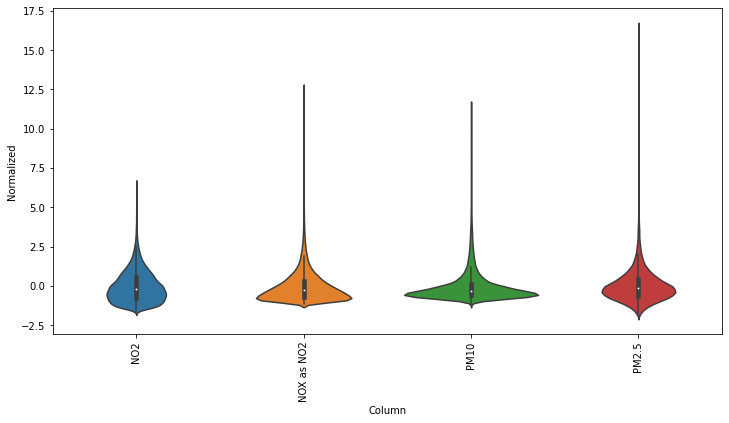

In [578]:
# Visualization of normalized values
df_std = (lstm_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(lstm_df.keys(), rotation=90)

In [98]:
# Metric - Mean Absolute Percentage Error suggested by Shengui Li
def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                         / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

In [99]:
# Group the timestamp dataset into days format
def split_dataset(train,val,test):
    # split into days and restructure into windows of daily data
    train = array(split(train, len(train)/24))
    val = array(split(val, len(val)/24))
    test = array(split(test, len(test)/24))
    return train,val,test

In [100]:
train, val, test = split_dataset(training_set.values,validation_set.values,testing_set.values)
print("Data format: [Samples,Timesteps,Features]")
print('Training data:',train.shape,'\nValidation data:',val.shape,'\nTesting data:',test.shape)

Data format: [Samples,Timesteps,Features]
Training data: (1369, 24, 8) 
Validation data: (365, 24, 8) 
Testing data: (92, 24, 8)


In [117]:
# convert history into inputs and outputs format of 24 hours history and 24 hours forecast
def to_supervised(train, n_input=24, n_out=24):
    # flatten data into timestamps data format
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0:4]) # Change the 2nd dimension according to the num of features to be predicted 
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [118]:
# Build the LSTM model architecture and train the model
def build_model(train,val,n_input,n_out_features):
    
    # prepare the training and validation data by sequencing them as window of 24 hours data 
    train_x, train_y = to_supervised(train, n_input)
    val_x, val_y = to_supervised(val,n_input)
    
    # define the model parameters
    verbose, epochs, batch_size = 2, 30, 80
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # define the model architecture
    model = Sequential()
    
    # Single feature prediction
    #model.add(LSTM(50, activation='relu',input_shape=(n_timesteps, n_features)))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(n_outputs))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
    
    # Multi features predictions
    #model.add(LSTM(50, activation='relu',
              #input_shape=(n_timesteps, n_features)))
    #model.add(Attention(name='attention_weight'))
    #model.add(Dropout(0.50))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.50))
    #model.add(Dense(n_outputs*n_out_features))
    #model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))  # Reshape the output layer back into [Timesteps,out_featrs]
    
    #CNN + LSTM
    #model.add(Conv1D(filters=6, kernel_size=2,
    #                  strides=1, 
    #                  padding="same",
    #                  activation="tanh",
    #                  input_shape=[n_timesteps, n_features])),
    #model.add(Conv1D(filters=16, kernel_size=2,
    #                  strides=1,padding="valid",
    #                  activation="tanh"))
    #model.add(AveragePooling1D()),
    
    #model.add(LSTM(50, activation='tanh'))
    #model.add(Attention(name='attention_weight'))
    #model.add(Dropout(0.50))
    #model.add(Dense(100, activation='tanh'))
    #model.add(Dropout(0.50))
    #model.add(Dense(n_outputs*n_out_features))
    #model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))  # Reshape the output layer back into [Timesteps,out_featrs]
    
    #LSTM model
    model.add(LSTM(50, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.50))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.50))
    model.add((Dense(n_outputs*n_out_features)))
    model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    
    #GRU
    #model.add(GRU(50, activation='relu',
    #          input_shape=(n_timesteps, n_features)))
    #model.add(Dropout(0.50))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.50))
    #model.add(Dense(n_outputs*n_out_features))
    #model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    
    #Bi-directional LSTMS
    #model.add(Bidirectional(LSTM(50,return_sequences=True,
    #                       input_shape=(n_timesteps, n_features))))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(TimeDistributed(Dense(n_out_features)))
    #model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    model.compile(loss='mae', optimizer='adam')
    
    # fit the network
    history = model.fit(train_x, train_y, epochs=epochs, 
                        batch_size=batch_size,shuffle=False,
                        validation_data=(val_x, val_y),
                        #callbacks=[early_stopping],
                        verbose=verbose)
    
    # Plot the validation loss and training loss 
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    return model

In [119]:
# Make a forecast for next 24 hours
def forecast(model, history, n_input):
    # flatten the data into timestamps format
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations i.e last 24 hours for input data 
    input_x = data[-n_input:, :]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # forecast the next day
    yhat = model.predict(input_x, verbose=0)
    model.save('tf_lstm_model.h5')  
    return yhat[0]

In [120]:
# Evaluate the model
def evaluate_model(train,val,test, n_input,n_out_features):
    # fit model
    model = build_model(train,val,n_input,n_out_features)
    model.summary()
    # history is a list of daily data
    history = [x for x in val] #train]
    # walk-forward validation over each day  
    predictions = list()
    for i in range(len(test)):
        # predict the next day
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next day
        history.append(test[i, :])
    # evaluate predictions days for each day
    predictions = array(predictions)
    return predictions

Epoch 1/30
411/411 - 4s - loss: 0.6253 - val_loss: 0.5418
Epoch 2/30
411/411 - 4s - loss: 0.5756 - val_loss: 0.5341
Epoch 3/30
411/411 - 4s - loss: 0.5664 - val_loss: 0.5291
Epoch 4/30
411/411 - 4s - loss: 0.5613 - val_loss: 0.5248
Epoch 5/30
411/411 - 4s - loss: 0.5581 - val_loss: 0.5230
Epoch 6/30
411/411 - 4s - loss: 0.5555 - val_loss: 0.5183
Epoch 7/30
411/411 - 4s - loss: 0.5531 - val_loss: 0.5156
Epoch 8/30
411/411 - 4s - loss: 0.5508 - val_loss: 0.5135
Epoch 9/30
411/411 - 4s - loss: 0.5496 - val_loss: 0.5111
Epoch 10/30
411/411 - 4s - loss: 0.5481 - val_loss: 0.5065
Epoch 11/30
411/411 - 4s - loss: 0.5467 - val_loss: 0.5068
Epoch 12/30
411/411 - 4s - loss: 0.5453 - val_loss: 0.5045
Epoch 13/30
411/411 - 4s - loss: 0.5449 - val_loss: 0.5043
Epoch 14/30
411/411 - 4s - loss: 0.5435 - val_loss: 0.5037
Epoch 15/30
411/411 - 4s - loss: 0.5426 - val_loss: 0.5019
Epoch 16/30
411/411 - 4s - loss: 0.5424 - val_loss: 0.5014
Epoch 17/30
411/411 - 4s - loss: 0.5418 - val_loss: 0.4997
Epoch 

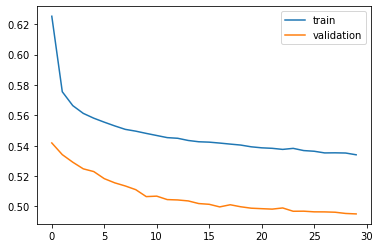

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                11800     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 96)                9696      
_________________________________________________________________
reshape_11 (Reshape)         (None, 24, 4)             0         
Total params: 26,596
Trainable params: 26,596
Non-trainable params: 0
_________________________________________________

In [121]:
# Main program starts from here - Firstly split the timestamp data into days format
train, val, test = split_dataset(training_set.values,validation_set.values,testing_set.values)

n_input = 24   # Number of previous timestamps needed to predict future data
n_out_features = 4  # features to be predicted [NO2,NOX as NO2, PM10 and PM2.5]

predictions = evaluate_model(train,val,test, n_input,n_out_features)

In [122]:
predictions.shape

(92, 24, 4)

# Collect the predicted values for the 4 pollutants, denormalize the values and calculate the SMAPE scores

In [123]:
# print(predictions.shape)
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error 
# Predictions for NO2, NOX as NO2, PM10 and PM2.5

pred_de_norm = {}
grnd_de_norm = {}
smape_scores = {}
avg_smape_score = 0 

df_write = pd.DataFrame(columns=['NO2','NOX as NO2','PM10','PM2.5'])
n_out = 24
for i in range(0,4):
    
    # Denormalize the predicted values
    #pred_de_norm[i] = ( predictions[:,:,i] * train_std[i] ) + train_mean[i]
    #grnd_de_norm[i] = ( test[:,:n_out,i] * train_std[i] ) + train_mean[i]
    
    pred_de_norm[i] = predictions[:,:,i]
    grnd_de_norm[i] = test[:,:n_out,i]
    
    # Reshape into 1D array
    grnd_de_norm[i] = grnd_de_norm[i].reshape(grnd_de_norm[i].shape[0]*grnd_de_norm[i].shape[1])
    pred_de_norm[i] = pred_de_norm[i].reshape(pred_de_norm[i].shape[0]*pred_de_norm[i].shape[1])

    pred_de_norm[i] = pred_de_norm[i].astype('float32')
    grnd_de_norm[i] = grnd_de_norm[i].astype('float32')
    
    #smape_scores[i] = smape(grnd_de_norm[i],pred_de_norm[i])
    smape_scores[i] = mean_absolute_error(grnd_de_norm[i],pred_de_norm[i]) 
    
    avg_smape_score = avg_smape_score + smape_scores[i]
    
    col = df_write.columns[i]
    df_write[col] = pred_de_norm[i]
    
#df_write.insert(loc=0, column='Start', value=date_time[41616:].values)
avg_smape_score = avg_smape_score / 4
print("\nSmape score for all 4 pollutants:",smape_scores)
print("\nAverage smape score:",avg_smape_score)


Smape score for all 4 pollutants: {0: 0.49246785, 1: 0.41881132, 2: 0.3254705, 3: 0.50455797}

Average smape score: 0.435326911509037


In [126]:
model.save('tf_lstm_model.h5')

NameError: name 'model' is not defined

In [496]:
# Write the predicted values to a CSV file 
df_write.to_csv(r'2019/Combined/8779_output.csv')

# Plots for predicted and real values

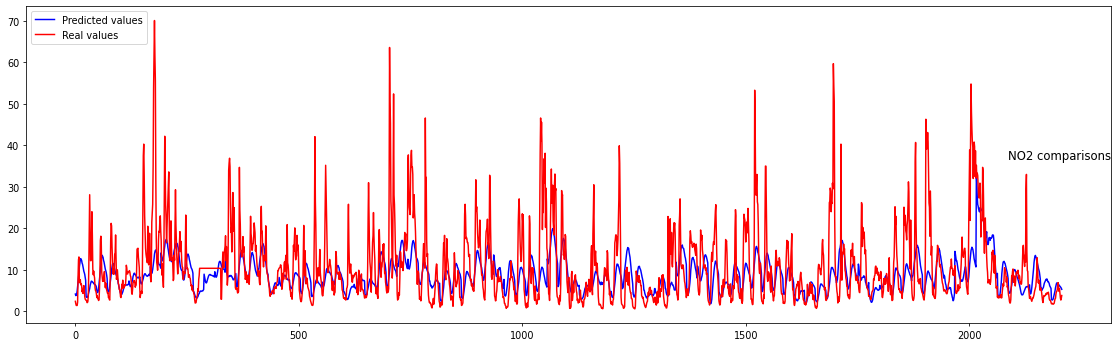

In [640]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[0], "-b", label="Predicted values")
plt.plot(grnd_de_norm[0], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', y=0.5, loc='right')
plt.show()

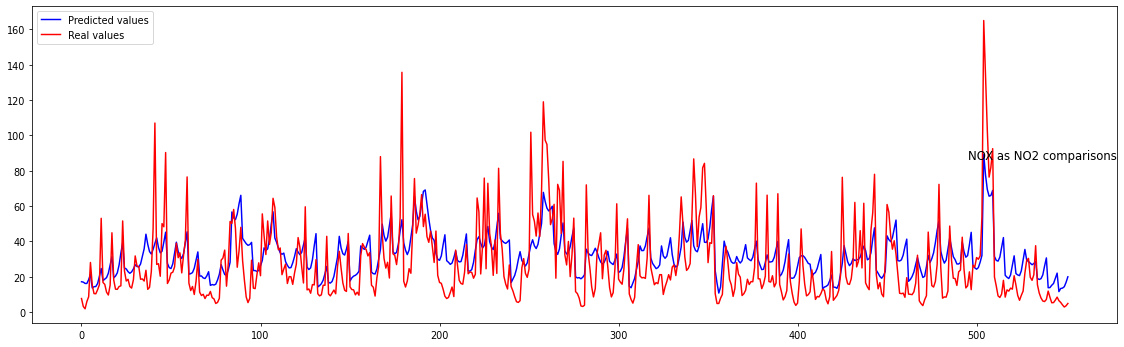

In [117]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[1], "-b", label="Predicted values")
plt.plot(grnd_de_norm[1], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NOX as NO2 comparisons', y=0.5, loc='right')
plt.show()

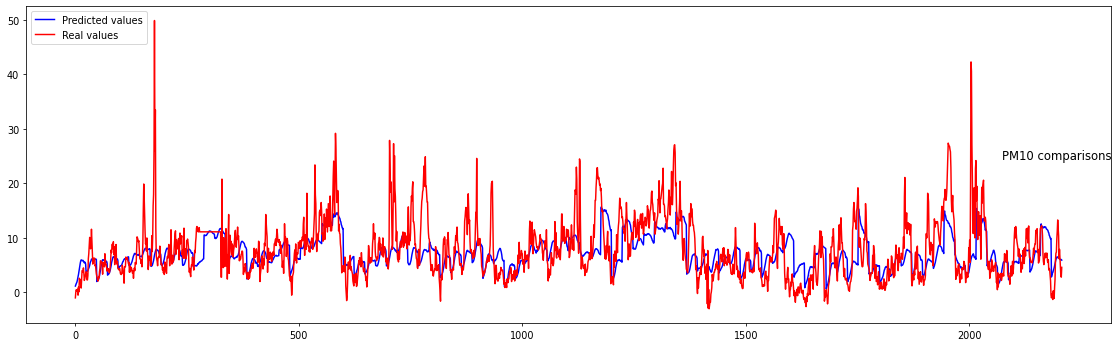

In [641]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[2], "-b", label="Predicted values")
plt.plot(grnd_de_norm[2], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('PM10 comparisons', y=0.5, loc='right')
plt.show()

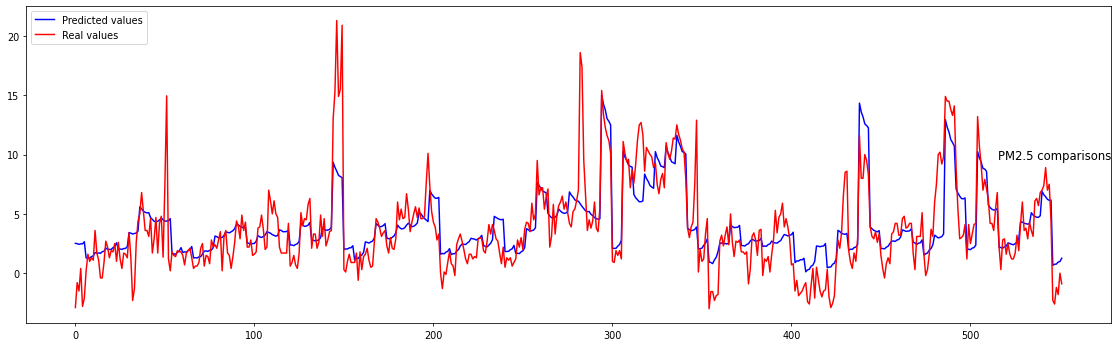

In [119]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[3], "-b", label="Predicted values")
plt.plot(grnd_de_norm[3], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('PM2.5 comparisons', y=0.5, loc='right')
plt.show()